## 温調測定用

In [1]:
import os, datetime, glob
import tkinter
from tkinter import filedialog
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit import Model, Parameters, Parameter

In [5]:
root = tkinter.Tk()
root.withdraw()
fld = filedialog.askdirectory(title ="Import")
##保存先のディレクトリを作成
InitialDir=os.getcwd()
date=datetime.datetime.now()
date=date.strftime('%Y%m%d_tmp')
Fpath=os.path.join(fld,date)
res=os.path.exists(Fpath)
if res==0:
    os.mkdir(Fpath)
os.chdir(Fpath)

In [10]:
data0 = glob.glob(fld+'/1-'+'*.txt')
data1 = glob.glob(fld+'/2-'+'*.txt')
data2 = glob.glob(fld+'/3-'+'*.txt')
data3 = glob.glob(fld+'/4-'+'*.txt')
data4 = glob.glob(fld+'/5-'+'*.txt')
data5 = glob.glob(fld+'/6-'+'*.txt')
data6 = glob.glob(fld+'/7-'+'*.txt')
data7 = glob.glob(fld+'/8-'+'*.txt')
dset=list([data0,data1,data2,data3,data4,data5,data6,data7])
print(data0[0])

C:/Users/USER/Desktop/study/進捗/20191010_温調/20191010frtemp\1-1007.txt


In [229]:
def lorentz(x,amplitude,center,sigma,m,b):
    out = amplitude/np.pi * (sigma/((x-center)**2+sigma**2)) + m * x + b
    return out

class FrTemp():
    def __init__(self,data,save=False):
        temp = np.array([])
        df = []
        fr = np.array([])
        for path in data:
            t = os.path.splitext(path)[0]
            t = int(t.split('-',1)[1])
            temp = np.append(temp,t)
            df0 = pd.read_csv(path,engine='python',header=None,sep='    ',index_col=0,names=('freq',t))
            df.append(df0)
        self.df = pd.concat(df,axis=1)
        self.df.sort_index(axis=1,ascending=True,inplace=True)
        self.temp = temp
        self.result = self.fit(self.df)
        
    def fit(self,df):
        out = []
        for col in df.columns:
            df1 = df.copy()
            df1 = df1[col]
            df1.dropna(how='any',inplace=True)
            #フィッティング  
            mod = Model(lorentz)
            par = Parameters()
            mask = df1 == df1.min()
            amp = pow(10,df1.values/10)
            x = df1.index.values * pow(10,-9)
            center = float(x[mask])
            par['amplitude'] = Parameter(name='amplitude',value=np.pi*(1-amp.min())*(x.max()-x.min())/20,vary=True)
            par['center']    = Parameter(name='center',value=center,min=center*0.9,max=center*1.1,vary=True)
            par['sigma']     = Parameter(name='sigma',value=pow(10,-5),min=0,max=1,vary=True)
            par['m']         = Parameter(name='m',value=0,vary=True)
            par['b']         = Parameter(name='b',value=1,vary=True)
            par['height']    = Parameter(name='height',expr='abs(amplitude/sigma/pi)',vary=False)
            par['fwhm']      = Parameter(name='fwhm',expr='2*sigma',vary=False)
            par['Ql']        = Parameter(name='Ql',expr='center/fwhm',vary=False)
            par['Qc']        = Parameter(name='Qc',expr='Ql/(1-height)',vary=False)
            par['Qi']        = Parameter(name='Qi',expr='Ql/height',vary=False)
            result = mod.fit(amp,par,x=x)
            result = pd.Series(result.values,name=str(col))
            out.append(result)
        out = pd.concat(out,axis=1)
        out = out.T
        out.index.rename('T[mK]',inplace=True)
        out['fwhm'] = out['fwhm']*pow(10,6)
        out.rename(columns={'center':'fr[GHz]','m':'slope','b':'const','fwhm':'FWHM[kHz]'},inplace=True)
        return out
    
    def tplot(self,frTemp,save=False):
        delta = (frTemp.loc[:,'fr[GHz]']-frTemp.iloc[0,1])/frTemp.iloc[0,1]*pow(10,6)
        plt.plot(round(frTemp.loc[:,'T[mK]']*pow(10,-3),2),delta,color='tab:blue',marker='o',linestyle='None',label='fr= '+str(round(frTemp.iloc[0,1],3))+'[GHz]')
        plt.xlabel('temparature[K]',fontsize=16)
        plt.ylabel('$\delta$f/f$\it_{0}$ x10$\it^{-6}$',fontsize=16)
        plt.legend(fontsize=12)
        plt.tight_layout()
        if save==True:
            plt.savefig(str(round(frTemp.iloc[0,1],3))+'[GHz]_delta.png')
        plt.show()
        
        plt.plot(round(frTemp.loc[:,'T[mK]']*pow(10,-3),2),frTemp.loc[:,'Q'],color='tab:orange',marker='o',linestyle='None',label='fr= '+str(round(frTemp.iloc[0,1],3))+'[GHz]')
        plt.xlabel('temparature[K]',fontsize=16)
        plt.ylabel('Q',fontsize=16)
        plt.legend(fontsize=12)
        plt.tight_layout()
        if save==True:
            plt.savefig(str(round(frTemp.iloc[0,1],3))+'[GHz]_Q.png')
        plt.show()

In [232]:
freqs = []
for data in dset:
    out = FrTemp(data,save=False)
    name = round(float(out.result['fr[GHz]'].iloc[0]),2)
    out.result.to_csv('fit_'+str(name)+'.csv')
    freqs.append(out)

In [235]:
freqs[0].result

,amplitude,fr[GHz],sigma,slope,const,height,FWHM[kHz],Ql,Qc,Qi
T[mK],,,,,,,,,,
546,-0.000020,3.248871,0.000034,-1.636185,5.531045,0.187144,67.279654,48289.050548,59406.659900,258031.300787
552,-0.000019,3.248866,0.000033,-1.646147,5.563241,0.188710,65.356735,49709.735395,61272.427798,263419.285641
592,-0.000019,3.248864,0.000033,-1.512535,5.127735,0.186431,66.420442,48913.615800,60122.261215,262368.651798
623,-0.000020,3.248860,0.000034,-1.452454,4.932965,0.185697,67.174149,48364.736311,59394.005931,260450.196092
939,-0.000020,3.248850,0.000034,-1.640920,5.546126,0.184100,68.049913,47742.162412,58514.752121,259326.761214
1007,-0.000020,3.248856,0.000034,-1.563066,5.292647,0.185384,67.006926,48485.376012,59519.328055,261539.744730
1065,-0.000020,3.248846,0.000034,-1.570755,5.317473,0.183052,68.546546,47396.202742,58016.168084,258922.320031
1076,-0.000020,3.248842,0.000035,-1.620136,5.477488,0.181712,69.089023,47023.996778,57466.349076,258782.440656
1096,-0.000020,3.248840,0.000035,-1.682553,5.680537,0.181631,69.716598,46600.667269,56943.315349,256568.382820


In [233]:
os.chdir(InitialDir)

In [2]:
root = tkinter.Tk()
root.withdraw()
file = filedialog.askopenfilename(title ="Import dir",filetypes=[('CSV','*.csv')])
data = pd.read_csv(file,engine='python',header=0,index_col=0)
data.head()

,w3,w9
T[mK],,
546.0,0.000000e+00,NaN
552.0,0.000000e+00,0.000000e+00
592.0,-6.155994e-07,NaN
617.0,NaN,-5.326368e-07
623.0,-1.846798e-06,NaN


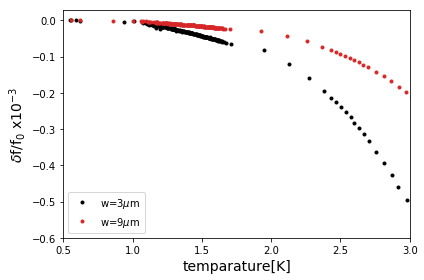

In [14]:
u3 = data['w3'].dropna()
u9 = data['w9'].dropna()
plt.plot(u3.index*pow(10,-3),u3*pow(10,3),marker='.',linestyle='None',color='black',label='w=3$\mu$m')
plt.plot(u9.index*pow(10,-3),u9*pow(10,3),marker='.',linestyle='None',color='tab:red',label='w=9$\mu$m')
plt.xlabel('temparature[K]',fontsize=14)
plt.ylabel('$\delta$f/f$\it_{0}$ x10$\it^{-3}$',fontsize=14)
plt.xlim(0.5,3.0)
plt.legend()
plt.tight_layout()
plt.savefig('w3w9.png')
plt.show()

In [241]:
InitialDir

'C:\\Users\\USER\\Desktop\\study\\python\\jupyter\\digitizer'